#### About

- Load images and visualize their bounding boxes on top.
- Images can be from either the training set or test set.
- Bounding boxes can be either ground truth labels or predictions.
- Predictions can be from training, validation or test set.
- Render single box or prediction atop ground truth.

#### Load libraries

In [437]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [438]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from itertools import count

import shapely
from scorer import *

#### Download dataset

In [460]:
path = pathlib.Path.home()/'.fastai/data'
labels_dir = path/'labels'

In [516]:
! mkdir -p $path; 
# get training set
! cd $path; if [ ! -d Data_Training ]; then wget -nc https://s3.amazonaws.com/herox-alphapilot/Data_Training.zip; unzip -n -q Data_Training.zip; fi
# get test set
! cd $path; if [ ! -d Data_LeaderboardTesting ]; then wget -nc https://s3.amazonaws.com/herox-alphapilot/Data_LeaderboardTesting.zip; unzip -n -q Data_LeaderboardTesting.zip; fi
# copy labels from git
! mkdir -p $path/labels
! cp -r labels $path/
# copy submission from git
#! cp -r submission $path/
# copy results from git
! cp -r results $path/

#### Define helper functions

In [481]:
# given a filename, prediction and ground truth, calculate IOU
def calc_iou(fname, df_pred, df_gt):
    mAP_scorer = mAPScorer()
    
    pred_poly = mAP_scorer.create_poly(df_pred[fname][0][0: 8])
    gt_poly = mAP_scorer.create_poly(df_gt[fname][0])
    return mAP_scorer.calculate_iou(pred_poly, gt_poly)

In [482]:
# given a filename and dataframe, return a bounding box (as a matplotlib PathPatch)
def patch(fname, df, color, fill=False):
    #fname = df.keys()[id]
    
    # load the bounding box from the dataframe
    bbox = df[fname][0]
    
    # convert to array of vertices
    try:
        vertices = [(bbox[x], bbox[x+1]) for x in range(0,8,2)]
        vertices += [(0, 0)]
    except:
        vertices = [(0, 0)] * 5

    # create a patch based on the verticies
    codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
    vertices = np.array(vertices, float)
    path = Path(vertices, codes)
    return PathPatch(path, facecolor=color, edgecolor=color, linewidth=3, fill=fill)

In [483]:
# render images with a single bounding box
# id can be either image filename or dataframe index
def show_box(id, img_dir, df, color, figsize):
    if type(id) == str:
        idx = list(df.keys()).index(id)
        fig, axs = plt.subplots(1, 1, figsize=figsize)
        axs = [[axs]]
        
    elif type(id) == int:
        idx = id
        fig, axs = plt.subplots(3, 3, figsize=figsize)
    
    for row_axs in axs:
        for ax in row_axs:
            fname = df.keys()[idx]
            img = mpimg.imread(img_dir/fname)
            pathpatch = patch(fname, df, color=color)  # get bounding box
            # render a couple to dots to see which way the coordinates flow
            ax.scatter(*tuple(df[fname][0][:2]), c='blue', s=75)    # little dot
            ax.scatter(*tuple(df[fname][0][2:4]), c='blue', s=300)  # big dot
            ax.imshow(img)
            ax.set_title(fname)
            ax.axis('on')
            ax.add_patch(pathpatch)
            idx += 1
            print(fname)
            #print(pathpatch.get_path())

    plt.show()

In [484]:
# render images with two bounding boxes
# id can be either image filename or dataframe index
def show_boxes(id, img_dir, df_pred, df_gt, figsize, use_iou=False):
    if type(id) == str:
        idx = list(df_pred.keys()).index(id)
        fig, axs = plt.subplots(1, 1, figsize=figsize)
        axs = [[axs]]
        
    elif type(id) == int:
        idx = id
        fig, axs = plt.subplots(3, 3, figsize=figsize)
    
    for row_axs in axs:
        for ax in row_axs:
            if use_iou == True:
                fname = ious[idx][0]
            else:
                fname = df_pred.keys()[idx]
            iou = calc_iou(fname, df_pred, df_gt)
            img = mpimg.imread(img_dir/fname)
            # pred box
            pathpatch_pred = patch(fname, df_pred, color='red', fill=False)      # bounding box
            #ax.scatter(*tuple(df_pred[fname][0][:2]), c='red', s=75)    # little dot
            #ax.scatter(*tuple(df_pred[fname][0][2:4]), c='red', s=300)  # big dot
            # gt box
            pathpatch_gt = patch(fname, df_gt, color='green', fill=True)        # bounding box
            ax.scatter(*tuple(df_gt[fname][0][:2]), c='blue', s=75)    # little dot
            ax.scatter(*tuple(df_gt[fname][0][2:4]), c='blue', s=300)  # big dot
            ax.imshow(img)
            title = '{} {:.2f}'.format(fname, iou)
            ax.set_title(title)
            ax.axis('off')
            # render preds on top of gts
            ax.add_patch(pathpatch_gt)
            ax.add_patch(pathpatch_pred)
            idx += 1
            print(fname)
            #print(pathpatch_gt.get_path())

    plt.show()

In [485]:
def show_preds(id, figsize=(17,17)):
    show_box(id, img_dir, df_pred, 'red', figsize)  # ignore dirty hack grabbing globals

In [486]:
def show_gts(id, figsize=(17,17)):
    show_box(id, img_dir, df_gt, 'green', figsize)  # ignore dirty hack grabbing globals

In [487]:
def show_preds_and_gts(id, figsize=(17,17), use_iou=False):
    show_boxes(id, img_dir, df_pred, df_gt, figsize, use_iou)  # ignore dirty hack grabbing globals

#### Configure

In [488]:
# which images?

img_dir = path/'Data_Training'              # train
#img_dir = path/'Data_LeaderboardTesting'   # test

In [489]:
# which ground truths?

#gt_path = labels_dir/'training_GT_labels_v2.json'      # official
#gt_path = labels_dir/'training_community_labels.json'  # community
gt_path = labels_dir/'training_superclean_labels.json'    # combined 
#gt_path = labels_dir/'good_community_labels/trainingdata_6000-to-6499_good.json'


df_gt = pd.read_json(gt_path)

In [517]:
# which predictions?
pred_path = path/'results/results_v20run2_stage21_train.json'    # choose train, valid or test
#pred_path = path/'submission/random_submission.json'

df_pred = pd.read_json(pred_path)

In [518]:
# create iou list sorted from worst to best
ious = []
for key in df_pred.keys():
    try:
        ious.append([key, calc_iou(key, df_pred, df_gt)])
    except:
        print(f'{key} not found')
        #ious.append([key, 0.0])
ious.sort(key = lambda x: x[1], reverse=False)

In [519]:
# sanity check the numbers
print('images:      ', len([fname for fname in os.listdir(img_dir) if fname.endswith('JPG')]))
print('gt labels:   ', len(df_gt.keys()))
print('pred labels: ', len(df_pred.keys()))
print('ious:        ', len(ious))

images:       9339
gt labels:    9253
pred labels:  48
ious:         48


#### Render single images

In [500]:
#show_preds('IMG_8643.JPG')

In [433]:
#show_gts('IMG_1463.JPG')

In [404]:
#show_preds('IMG_0342.JPG')

IMG_1204.JPG


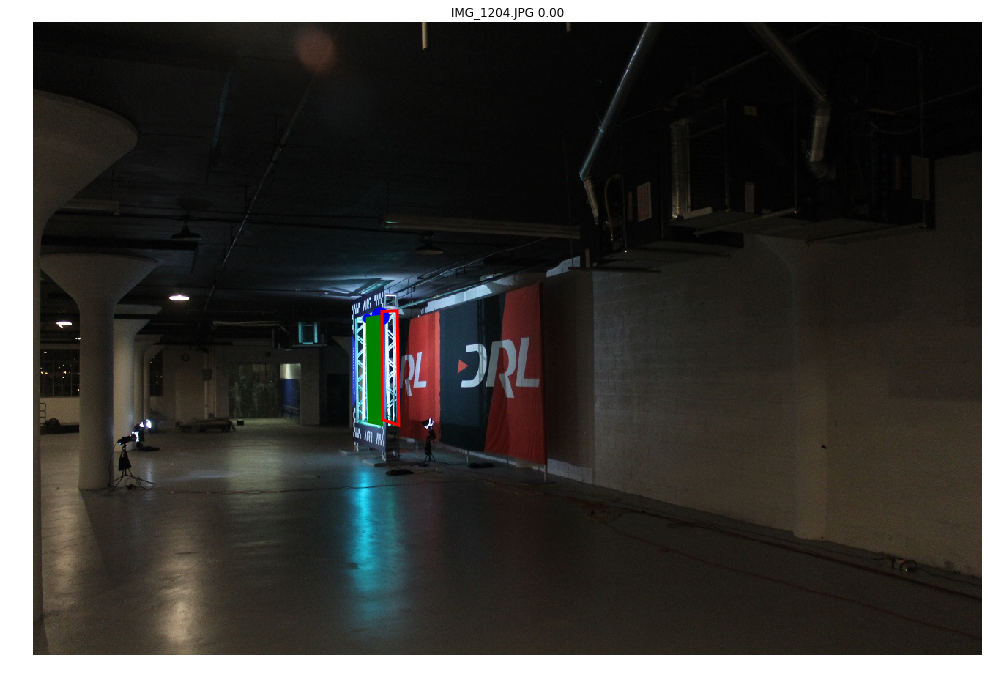

In [523]:
show_preds_and_gts('IMG_1204.JPG')

In [372]:
# create file name generator
#fnames = iter(df_pred.keys())
fnames = iter(ious)

In [373]:
# each time this is run it will generate a new image
#show_preds_and_gts(next(fnames)[0])

#### Render sets of images

In [520]:
# create index generator
counter = count(start=0, step=9)

In [521]:
counter

count(0, 9)

IMG_1204.JPG
IMG_1752.JPG
IMG_1465.JPG
IMG_1175.JPG
IMG_4751.JPG
IMG_6126.JPG
IMG_1202.JPG
IMG_1777.JPG
IMG_0716.JPG


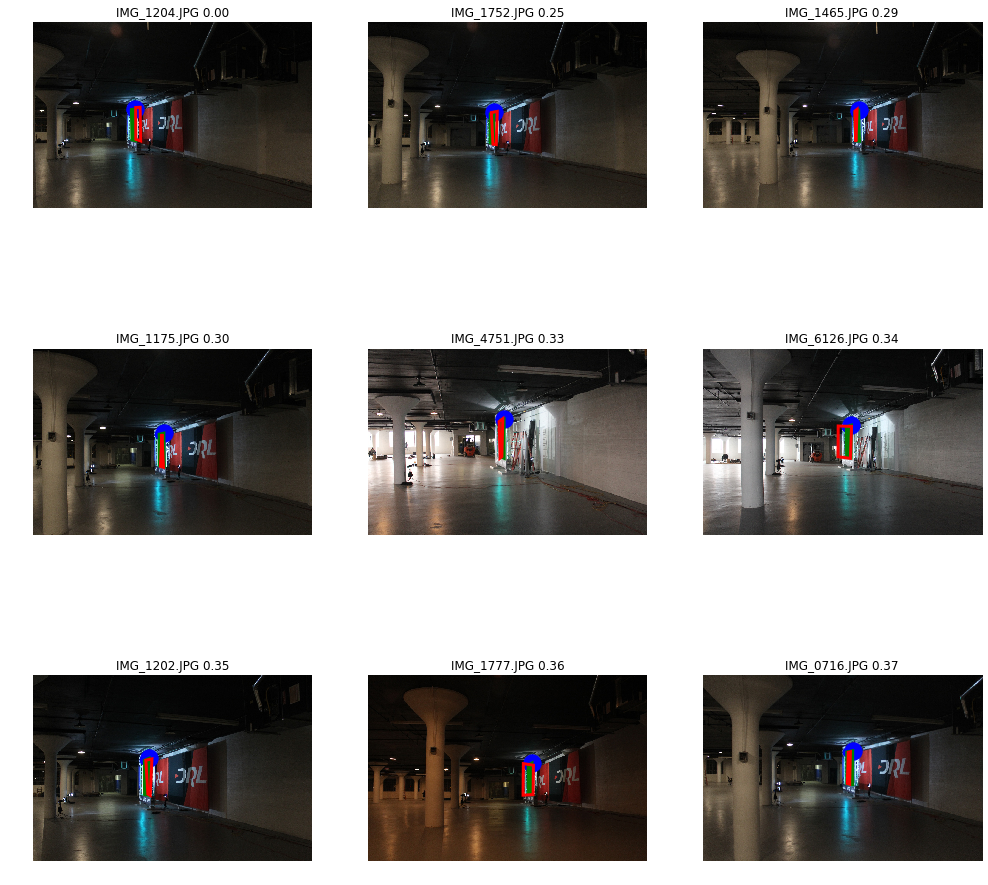

In [522]:
# each time this is run it will generate a new images
#show_images_with_bboxs(next(counter), img_dir, df_gt)
show_preds_and_gts(next(counter), use_iou=True)

In [334]:
#show_gts(next(counter))

In [84]:
#show_preds(next(counter))

## DEBUG

In [ ]:
df_gt['IMG_3306.JPG']

In [ ]:
# "IMG_3306.JPG": [[568, 323, 589, 645, 670, 626, 639, 226]]

In [ ]:
# ONLY RUN TO VISUALIZE BAD LABELS


# load bad labels from file
bad_labels_path = path/'bad_official_tmp2.txt'
with open(bad_labels_path,'r') as f:
    bad_labels = f.readlines()

bad_labels = [item.strip('\n') for item in bad_labels if item.startswith('IMG')]

# load only the bad labels into the dataframe
for id in df_gt.keys():
    if id not in bad_labels:
        df_gt = df_gt.drop(id, 1)
        
len(bad_labels)
